In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import comet_ml
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
#import torch
from pathlib import Path

from src.wsilib import WSIDatabase, WSITileDatabase
#from src.models import get_model_unet, get_model_maskrcnn, get_model_resnet34

In [4]:
datapath = Path("/storage01/bolma/dev/data/BIOMAG_slides/Lung")

# WSI preprocessing

In [141]:
database = WSIDatabase(wsi_dir=datapath)


ℹ️ Found 52 .mrxs files in /storage01/bolma/dev/data/BIOMAG_slides/Lung


Loading annotations...: 100%|██████████| 52/52 [00:31<00:00,  1.68it/s]


✅ Loaded 52 WSIs with annotations


In [144]:
database.save_coco_dataset(output_dir="/storage01/bolma/dev/data/datasets/WSI-ROI/slides", level=8)

Processing images...: 100%|██████████| 52/52 [00:26<00:00,  2.00it/s]


✅ Dataset saved to /storage01/bolma/dev/data/datasets/WSI-ROI/slides. Number of images: 52


In [42]:
tile_db = WSITileDatabase(
    wsi_dir=datapath,
    tile_size=256,
    level=6
)


ℹ️ Found 52 .mrxs files in /storage01/bolma/dev/data/BIOMAG_slides/Lung


Creating tile containers for each WSI: 100%|██████████| 52/52 [00:25<00:00,  2.03it/s]


✅ Created 52 tile containers


In [43]:
tile_db.save_dataset(Path("/storage01/bolma/dev/data/datasets/WSI-ROI/tiles"))

Extracting tiles from 3722_17_HE_40x: 1224 tiles [00:01, 1140.33 tiles/s]                     
Extracting tiles from 779_17_HE_40x: 1224 tiles [00:01, 1143.23 tiles/s]                     
Extracting tiles from 5342_24_A6: 1224 tiles [00:01, 704.71 tiles/s]                      
Extracting tiles from 2336_17_HE_40x: 1224 tiles [00:01, 966.74 tiles/s]                      
Extracting tiles from 12104_24_A4: 1224 tiles [00:01, 857.03 tiles/s]                       
Extracting tiles from 7532_21_A2_HE_20240515_2: 1224 tiles [00:01, 724.57 tiles/s]                     
Extracting tiles from 8394_24_A4: 1224 tiles [00:02, 493.98 tiles/s]                     
Extracting tiles from 518_17_HE_40x: 1224 tiles [00:01, 981.43 tiles/s]                      
Extracting tiles from 1968_17_HE_40x: 1224 tiles [00:00, 1625.97 tiles/s]                      
Extracting tiles from 1170_17_HE_40x: 1224 tiles [00:01, 1216.36 tiles/s]                     
Extracting tiles from 779-21_a2_HE_20230308_8: 1224 t


ℹ️ Merging annotations...

✅ Dataset saved to /storage01/bolma/dev/data/datasets/WSI-ROI/tiles. Total images: 6064


# Datasets

In [5]:
from src.utils.coco import COCODataset
from torch.utils.data import DataLoader
from src.utils.pretty_print import *

In [6]:
slide_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/slides/annotations.json")

In [31]:
train_dataset = COCODataset(
    annotation_file=slide_path,
    train=True,
    transform=None,
    random_seed=42,
)

test_dataset = COCODataset(
    annotation_file=slide_path,
    train=False,
    transform=None,
    random_seed=42,
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded training set with 41 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded test set with 11 images

Training image id-s: 	{0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 51}

Test image id-s: 	{32, 3, 5, 41, 43, 12, 13, 47, 17, 50, 19}

✅ Datasets are properly split and ready to use!


## Dataloaders

In [8]:
BATCH_SIZE = 1
NUM_WORKERS = 2

In [32]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


ℹ️ Created DataLoaders with batch size 1
	- Training batches: 41
	- Test batches: 11


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataloader_batch(dataloader, num_images=2, figsize=(15, 4)):
    """Visualize a batch of images and their masks from a dataloader.
    
    Args:
        dataloader: PyTorch dataloader containing (image, target) pairs
        num_images: Number of images to display (default: 2)
        figsize: Figure size (width, height) in inches
    """
    # Get a batch
    images, targets = next(iter(dataloader))
    
    # Create subplot grid: 1 row x num_images columns
    plt.figure(figsize=figsize)
    
    for idx in range(min(num_images, len(images))):
        # Get image and normalize for display
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        
        # Plot original image
        plt.imshow(img)
        
        # Create combined mask
        masks = targets['masks'][idx]
        combined_mask = torch.zeros_like(masks[0])
        
        # Combine all masks
        for mask in masks:
            combined_mask = torch.logical_or(combined_mask, mask)
        
        # Create mask overlay
        mask_img = combined_mask.cpu().numpy()
        overlay = img.copy()
        overlay[mask_img == 1] = np.array([1, 0, 0])  # Red color for masks
        plt.imshow(overlay, alpha=0.3)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Training Dataset Examples:


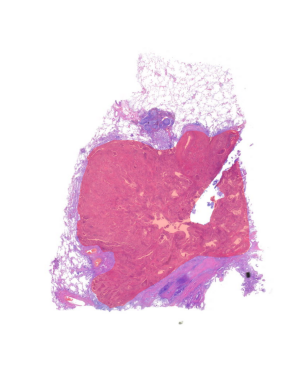


Test Dataset Examples:


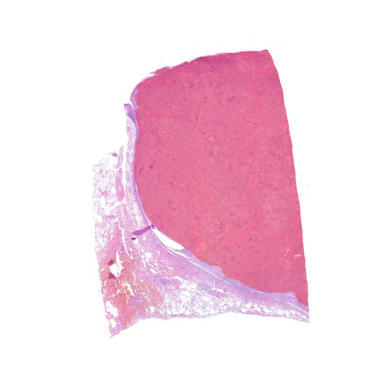

In [35]:
import warnings
# Visualize training data
print("Training Dataset Examples:")
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    visualize_dataloader_batch(train_dataloader)

# Visualize test data
print("\nTest Dataset Examples:")
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    visualize_dataloader_batch(test_dataloader)

# Training

In [12]:
import torch
from src.models import get_model_unet, get_model_maskrcnn, get_model_resnet34
from src.utils.train import maskrcnn_training_testing_loop

## Mask R-CNN

In [ ]:
maskrcnn = get_model_maskrcnn(num_classes=2, 
                      box_score_thresh=0.1,
                      box_nms_thresh=0.3,
                      box_fg_iou_thresh=0.5,
                      box_bg_iou_thresh=0.4,
                      box_detections_per_img=5,
                      image_mean = [0.485, 0.456, 0.406],
                      image_std = [0.229, 0.224, 0.225])

optimizer = torch.optim.SGD(maskrcnn.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

ValueError: SequentialLR does not support `ReduceLROnPlateau` scheduler as it requires additional kwargs to be specified when calling `step`, but got one at index 1 in the given schedulers sequence.

### Comet logging

In [14]:
from src.utils.comet import CometLogger
from dotenv import load_dotenv
import os

### Training loop

In [68]:
import warnings

load_dotenv()
api_key = os.getenv('COMET_API_KEY')

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.')

    comet_logger = CometLogger(api_key=api_key,
                            project_name="msc-thesis",
                            experiment_name="MaskRCNN",
                            log_env_details=False,)


with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    maskrcnn_training_testing_loop(maskrcnn,device, train_dataloader, optimizer, scheduler, n_epochs=30, box_score_thresh=0.5, comet_logger=comet_logger)

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : MaskRCNN
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/43f7ed7067f84e9a9fb63ed5f800b1f7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou               : 0.2817458179694124
COMET INFO:     learning_rate     : 0.01
COMET INFO:     loss [9]          : (0.4495711624622345, 1.5567625761032104)
COMET INFO:     test_loss         : 0.9268462657928467
COMET INFO:     training_loss [2] : (0.9000000953674316, 1.2767685651779175)
COMET INFO:   Others:
COMET INFO:     Name : MaskRCNN
COMET INFO:   Uploads:
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/bolf-marton/msc-thesis/a0dda5c5ce5c43418d3ece629684d23d




🚀 STARTING TRAINING
---------------------
Epoch 1/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  6.21it/s]


Train – Mean Loss: 1.2084


100%|██████████| 41/41 [00:06<00:00,  6.43it/s]


Test – IoU: 0.3944, Loss: 1.1715
---------------------
Epoch 2/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


Train – Mean Loss: 1.0905


100%|██████████| 41/41 [00:06<00:00,  6.20it/s]


Test – IoU: 0.4701, Loss: 0.8706
---------------------
Epoch 3/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:05<00:00,  7.09it/s]


Train – Mean Loss: 1.0044


100%|██████████| 41/41 [00:06<00:00,  6.79it/s]


Test – IoU: 0.4064, Loss: 0.8542
---------------------
Epoch 4/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  6.36it/s]


Train – Mean Loss: 0.9081


100%|██████████| 41/41 [00:06<00:00,  6.29it/s]


Test – IoU: 0.3932, Loss: 0.8289
---------------------
Epoch 5/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  6.04it/s]


Train – Mean Loss: 0.8944


100%|██████████| 41/41 [00:06<00:00,  6.40it/s]


Test – IoU: 0.5294, Loss: 0.7799
---------------------
Epoch 6/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  6.33it/s]


Train – Mean Loss: 0.7838


100%|██████████| 41/41 [00:06<00:00,  6.65it/s]


Test – IoU: 0.3472, Loss: 0.7161
---------------------
Epoch 7/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  5.98it/s]


Train – Mean Loss: 0.6930


100%|██████████| 41/41 [00:06<00:00,  6.32it/s]


Test – IoU: 0.4732, Loss: 0.6440
---------------------
Epoch 8/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


Train – Mean Loss: 0.6574


100%|██████████| 41/41 [00:06<00:00,  6.16it/s]


Test – IoU: 0.4514, Loss: 0.5779
---------------------
Epoch 9/30 - MaskRCNN
---------------------


100%|██████████| 41/41 [00:06<00:00,  6.08it/s]


Train – Mean Loss: 0.6222


100%|██████████| 41/41 [00:06<00:00,  6.14it/s]


Test – IoU: 0.4852, Loss: 0.5394
----------------------
Epoch 10/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.04it/s]


Train – Mean Loss: 0.5136


100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


Test – IoU: 0.4720, Loss: 0.4779
----------------------
Epoch 11/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.37it/s]


Train – Mean Loss: 0.4624


100%|██████████| 41/41 [00:06<00:00,  6.61it/s]


Test – IoU: 0.4799, Loss: 0.4475
----------------------
Epoch 12/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.21it/s]


Train – Mean Loss: 0.4372


100%|██████████| 41/41 [00:06<00:00,  6.66it/s]


Test – IoU: 0.4770, Loss: 0.4168
----------------------
Epoch 13/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.03it/s]


Train – Mean Loss: 0.4155


100%|██████████| 41/41 [00:06<00:00,  6.71it/s]


Test – IoU: 0.4693, Loss: 0.3919
----------------------
Epoch 14/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.31it/s]


Train – Mean Loss: 0.3892


100%|██████████| 41/41 [00:06<00:00,  6.20it/s]


Test – IoU: 0.4756, Loss: 0.3877
----------------------
Epoch 15/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:05<00:00,  6.95it/s]


Train – Mean Loss: 0.3881


100%|██████████| 41/41 [00:06<00:00,  6.39it/s]


Test – IoU: 0.4758, Loss: 0.3847
----------------------
Epoch 16/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.23it/s]


Train – Mean Loss: 0.3840


100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


Test – IoU: 0.4807, Loss: 0.3761
----------------------
Epoch 17/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  5.96it/s]


Train – Mean Loss: 0.3793


100%|██████████| 41/41 [00:05<00:00,  7.01it/s]


Test – IoU: 0.4717, Loss: 0.3816
----------------------
Epoch 18/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.39it/s]


Train – Mean Loss: 0.3744


100%|██████████| 41/41 [00:06<00:00,  6.02it/s]


Test – IoU: 0.4802, Loss: 0.3819
----------------------
Epoch 19/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.36it/s]


Train – Mean Loss: 0.3779


100%|██████████| 41/41 [00:06<00:00,  6.78it/s]


Test – IoU: 0.4724, Loss: 0.3777
----------------------
Epoch 20/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.27it/s]


Train – Mean Loss: 0.3747


100%|██████████| 41/41 [00:06<00:00,  6.01it/s]


Test – IoU: 0.4848, Loss: 0.3780
----------------------
Epoch 21/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.02it/s]


Train – Mean Loss: 0.3774


100%|██████████| 41/41 [00:06<00:00,  6.13it/s]


Test – IoU: 0.4878, Loss: 0.3764
----------------------
Epoch 22/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.48it/s]


Train – Mean Loss: 0.3758


100%|██████████| 41/41 [00:06<00:00,  6.36it/s]


Test – IoU: 0.4856, Loss: 0.3739
----------------------
Epoch 23/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.36it/s]


Train – Mean Loss: 0.3738


100%|██████████| 41/41 [00:06<00:00,  6.28it/s]


Test – IoU: 0.4696, Loss: 0.3760
----------------------
Epoch 24/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.07it/s]


Train – Mean Loss: 0.3788


100%|██████████| 41/41 [00:06<00:00,  6.11it/s]


Test – IoU: 0.4732, Loss: 0.3715
----------------------
Epoch 25/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.35it/s]


Train – Mean Loss: 0.3783


100%|██████████| 41/41 [00:06<00:00,  6.57it/s]


Test – IoU: 0.4820, Loss: 0.3754
----------------------
Epoch 26/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:05<00:00,  7.04it/s]


Train – Mean Loss: 0.3780


100%|██████████| 41/41 [00:06<00:00,  6.02it/s]


Test – IoU: 0.4793, Loss: 0.3755
----------------------
Epoch 27/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.19it/s]


Train – Mean Loss: 0.3746


100%|██████████| 41/41 [00:06<00:00,  6.80it/s]


Test – IoU: 0.4836, Loss: 0.3757
----------------------
Epoch 28/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.18it/s]


Train – Mean Loss: 0.3726


100%|██████████| 41/41 [00:06<00:00,  6.36it/s]


Test – IoU: 0.4876, Loss: 0.3822
----------------------
Epoch 29/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.15it/s]


Train – Mean Loss: 0.3777


100%|██████████| 41/41 [00:06<00:00,  6.22it/s]


Test – IoU: 0.4867, Loss: 0.3752
----------------------
Epoch 30/30 - MaskRCNN
----------------------


100%|██████████| 41/41 [00:06<00:00,  6.31it/s]


Train – Mean Loss: 0.3776


100%|██████████| 41/41 [00:06<00:00,  6.58it/s]

Test – IoU: 0.4826, Loss: 0.3721


In [61]:
with torch.set_grad_enabled(False):
    comet_logger.upload_images(
        model = maskrcnn,
        device = device,
        dataloader = test_dataloader,
        confidence_thr = 0.5,
        entry_name = "sample_img",
        overwrite = True,
        indices = [0,1,2,3,4,5,6,7,8,9],
    )

In [64]:
comet_logger.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml CometLogger Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : MaskRCNN
COMET INFO:     url                   : https://www.comet.com/bolf-marton/msc-thesis/cf8c0d4035934bff8291396d84dc72ac
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     iou [20]           : (0.0, 0.3947790845349966)
COMET INFO:     learning_rate [20] : (1e-05, 0.01)
COMET INFO:     loss [86]          : (0.40882590413093567, 55.40547180175781)
COMET INFO:     test_loss [20]     : (0.9949111342430115, 2.192868232727051)
COMET INFO:     training_loss [20] : (0.9987791776657104, 10.655182838439941)
COMET INFO:   Others:
COMET INFO:     Name : MaskRCNN
COMET INFO:   Uploads:
COMET INFO:     filename                 : 1
COMET INFO:     git

COMET INFO: Uploading 26 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation


In [ ]:
torch.save(maskrcnn.state_dict(), "src/models/MaskRCNN_trained.pth")